# 로이터 뉴스 분류: 머신러닝 vs. 딥러닝(Bi-LSTM) 모델 성능 비교

## 목표
- [이전 실험](./news_classification_vocab_size.ipynb)에서 찾은 최적의 머신러닝 모델(`VotingClassifier`)과 PyTorch로 구현한 딥러닝 모델(`Bi-LSTM`)의 성능 비교

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## 1. 최적 조건 설정 및 데이터 로드

In [ ]:
OPTIMAL_NUM_WORDS = 20000

(x_train_full, y_train_full), (x_test, y_test) = reuters.load_data(num_words=OPTIMAL_NUM_WORDS, test_split=0.2)

print(f'Vocabulary Size: {OPTIMAL_NUM_WORDS}')
print(f'Full Train samples: {len(x_train_full)}')
print(f'Test samples: {len(x_test)}')

Vocabulary Size: 20000


기사 최대 길이: 2376
기사 평균 길이: 145.54
기사 길이 중앙값: 95.0
뉴스 기사 길이의 90% 지점: 313 단어


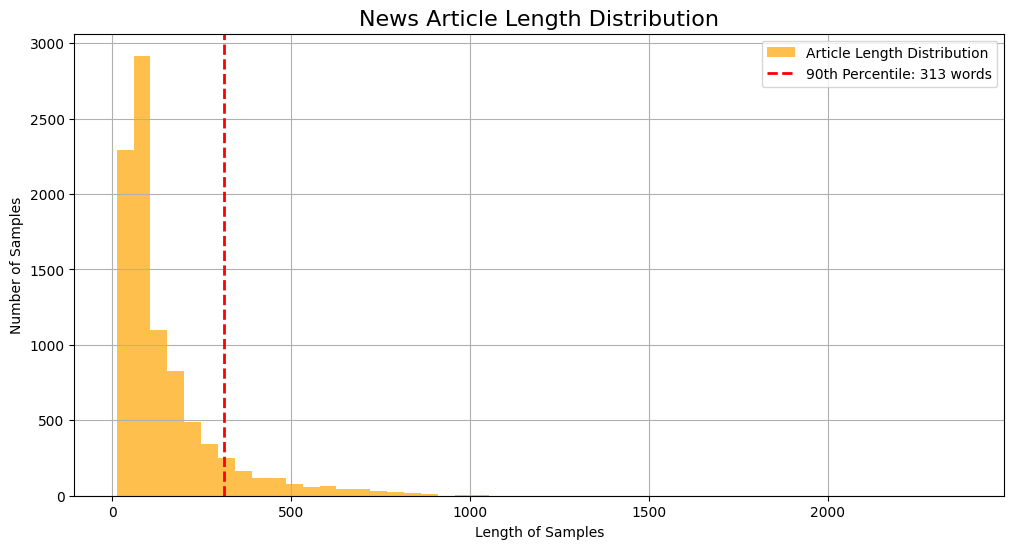

In [3]:
text_lengths = [len(s) for s in x_train_full]

# 90% 지점의 단어 길이 계산
percentile_90 = np.percentile(text_lengths, 90)

# 통계 정보 출력
print(f'기사 최대 길이: {np.max(text_lengths)}')
print(f'기사 평균 길이: {np.mean(text_lengths):.2f}')
print(f'기사 길이 중앙값: {np.median(text_lengths)}')
print(f'뉴스 기사 길이의 90% 지점: {int(percentile_90)} 단어')


# 히스토그램으로 시각화
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50, alpha=0.7, color='orange', label='Article Length Distribution')

# 90% 지점에 수직선 추가
plt.axvline(percentile_90, color='red', linestyle='--', linewidth=2, label=f'90th Percentile: {int(percentile_90)} words')

plt.title('News Article Length Distribution', fontsize=16)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
MAX_LEN = 300 # 딥러닝에서 쓸 길이, 90 기준

## 2. 비교 실험 1: 최적의 머신러닝 모델 (VotingClassifier)

In [5]:
# 데이터를 TF-IDF 행렬로 변환
x_train_str = [' '.join(map(str, doc)) for doc in x_train_full]
x_test_str = [' '.join(map(str, doc)) for doc in x_test]

vectorizer = CountVectorizer(token_pattern=r'[0-9]+').fit(x_train_str)
x_train_dtm = vectorizer.transform(x_train_str)
x_test_dtm = vectorizer.transform(x_test_str)

tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

# VotingClassifier 모델 정의 및 학습
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2', max_iter=3000)),
         ('cb', ComplementNB()),
         ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)

print('Training VotingClassifier...')
voting_classifier.fit(x_train_tfidf, y_train_full)
predicted = voting_classifier.predict(x_test_tfidf)
ml_accuracy = accuracy_score(y_test, predicted)

print(f'VotingClassifier 최종 정확도: {ml_accuracy:.4f}')

Training VotingClassifier...
VotingClassifier 최종 정확도: 0.8206


## 3. 비교 실험 2: PyTorch 딥러닝 모델 (Bidirectional LSTM)

In [16]:
# 1. Device 설정 (MPS 가속)
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

# 2. 데이터 패딩 및 Tensor 변환
x_train_pad = pad_sequences(x_train_full, maxlen=MAX_LEN)
x_test_pad = pad_sequences(x_test, maxlen=MAX_LEN)

# 3. Train / Validation 분리
x_train, x_val, y_train, y_val = train_test_split(x_train_pad, y_train_full, test_size=0.2, random_state=42)

# 4. DataLoader 생성
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 128
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Using device: mps


In [18]:
# PyTorch Bi-LSTM 모델 정의
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            batch_first=True, 
                            bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # Bidirectional이므로 *2
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # 마지막 time-step의 양방향 hidden state를 concat하여 사용
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

In [8]:
num_classes = len(np.unique(y_train_full))
print(f'로이터 뉴스의 카테고리(클래스) 개수: {num_classes}')

로이터 뉴스의 카테고리(클래스) 개수: 46


In [19]:
# 모델, 손실 함수, 옵티마이저 정의
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 46 # 로이터 뉴스의 카테고리 수

model = LSTMClassifier(OPTIMAL_NUM_WORDS, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
criterion = nn.CrossEntropyLoss().to(device) # 다중 분류이므로 CrossEntropyLoss 사용
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# 모델 학습
epochs = 30
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # 검증 데이터로 평가
    model.eval()
    val_loss, val_corrects = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            
    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_corrects.float()/len(val_data):.4f}')

Epoch 1/30 | Train Loss: 2.3557 | Val Loss: 2.0642 | Val Acc: 0.4480
Epoch 2/30 | Train Loss: 1.8265 | Val Loss: 1.7104 | Val Acc: 0.5960
Epoch 3/30 | Train Loss: 1.5026 | Val Loss: 1.5840 | Val Acc: 0.6160
Epoch 4/30 | Train Loss: 1.2446 | Val Loss: 1.5574 | Val Acc: 0.6466
Epoch 5/30 | Train Loss: 1.0667 | Val Loss: 1.5974 | Val Acc: 0.6327
Epoch 6/30 | Train Loss: 0.8952 | Val Loss: 1.5383 | Val Acc: 0.6600
Epoch 7/30 | Train Loss: 0.7216 | Val Loss: 1.4722 | Val Acc: 0.6839
Epoch 8/30 | Train Loss: 0.5917 | Val Loss: 1.5367 | Val Acc: 0.6733
Epoch 9/30 | Train Loss: 0.5095 | Val Loss: 1.5376 | Val Acc: 0.6900
Epoch 10/30 | Train Loss: 0.4165 | Val Loss: 1.5327 | Val Acc: 0.6867
Epoch 11/30 | Train Loss: 0.3375 | Val Loss: 1.6316 | Val Acc: 0.6733
Epoch 12/30 | Train Loss: 0.3274 | Val Loss: 1.6399 | Val Acc: 0.6850
Epoch 13/30 | Train Loss: 0.2727 | Val Loss: 1.6745 | Val Acc: 0.6867
Epoch 14/30 | Train Loss: 0.4621 | Val Loss: 1.6853 | Val Acc: 0.6572
Epoch 15/30 | Train Loss: 0.4

In [20]:
# 최종 평가
model.eval()
test_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).long()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

dl_accuracy = test_corrects.float() / len(test_data)
print(f'PyTorch Bi-LSTM 최종 정확도: {dl_accuracy:.4f}')

PyTorch Bi-LSTM 최종 정확도: 0.6541


## 4. 최종 결론

In [23]:
print(f'- 최적 머신러닝 모델 (VotingClassifier) 정확도: {ml_accuracy:.4f}')
print(f'- 딥러닝 모델 (Bi-LSTM) 정확도: {dl_accuracy:.4f}')

if dl_accuracy > ml_accuracy:
    print('>> 딥러닝 모델이 더 높은 성능을')
else:
    print('>> 머신러닝 앙상블 모델이 더 높은 성능')

- 최적 머신러닝 모델 (VotingClassifier) 정확도: 0.8206
- 딥러닝 모델 (Bi-LSTM) 정확도: 0.6541
>> 머신러닝 앙상블 모델이 더 높은 성능
